In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [139]:
df = pd.read_csv("data/nrl_with_cli_10k.csv")
train = df[df["date"].astype(str).str[:4].astype(int) < 2021]
# not even assigning test thanks
del df

Train is 2009 - 2020 inclusive, test is 2021 - 2024 inclusive. 

In [140]:
train["year"] = train["date"].str[:4]
train["date_mod_year"] = pd.to_datetime("2000" + train["date"].astype(str).str[4:])
train["date"] = pd.to_datetime(train["date"])

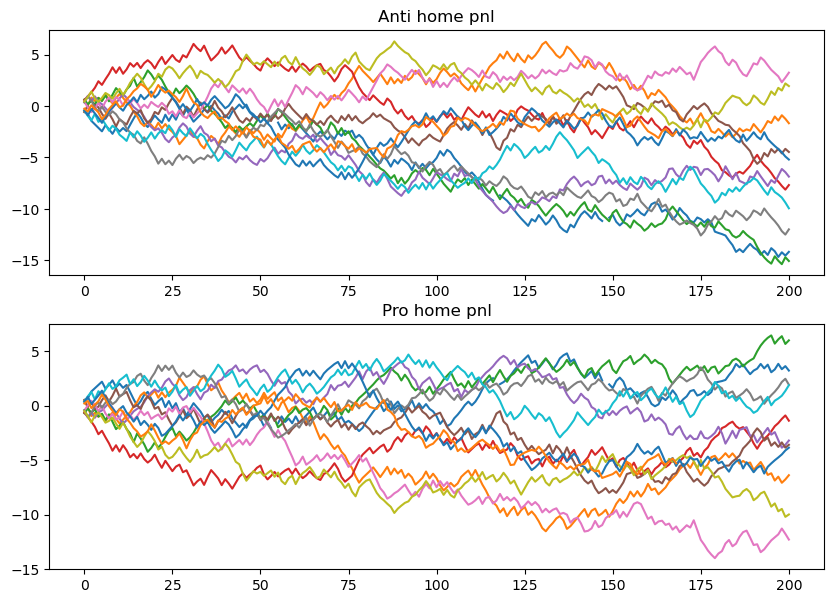

In [141]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
years = train["year"].unique()
for year in years:
    year_df = train[train["year"] == year]
    ax[0].plot(range(len(year_df)), year_df["anti_home_pnl"].cumsum())
    ax[1].plot(range(len(year_df)), year_df["pro_home_pnl"].cumsum())
ax[0].set_title("Anti home pnl")
ax[1].set_title("Pro home pnl")
plt.show()

In [142]:
def get_sharpe(s): return s.sum() / (s ** 2).sum() ** 0.5

In [143]:
get_sharpe(train[["anti_home_pnl", "pro_home_pnl"]])

anti_home_pnl   -3.260863
pro_home_pnl    -1.438704
dtype: float64

OK that's better...

In [144]:
def add_dog_pnl_inplace(df):
    df["underdog_pnl"] = np.where(
        df["home_bid"] > 0.5,
        df["home_bid"] - df["home_win"],
        0
    ) + np.where(
        df["home_ask"] < 0.5,
        df["home_win"] - df["home_ask"],
        0
    ) 
    df["favourite_pnl"] = np.where(
        df["home_bid"] > 0.5,
        df["home_win"] - df["home_ask"],
        0
    ) + np.where(
        df["home_ask"] < 0.5,
        df["home_bid"] - df["home_win"],
        0
    ) 

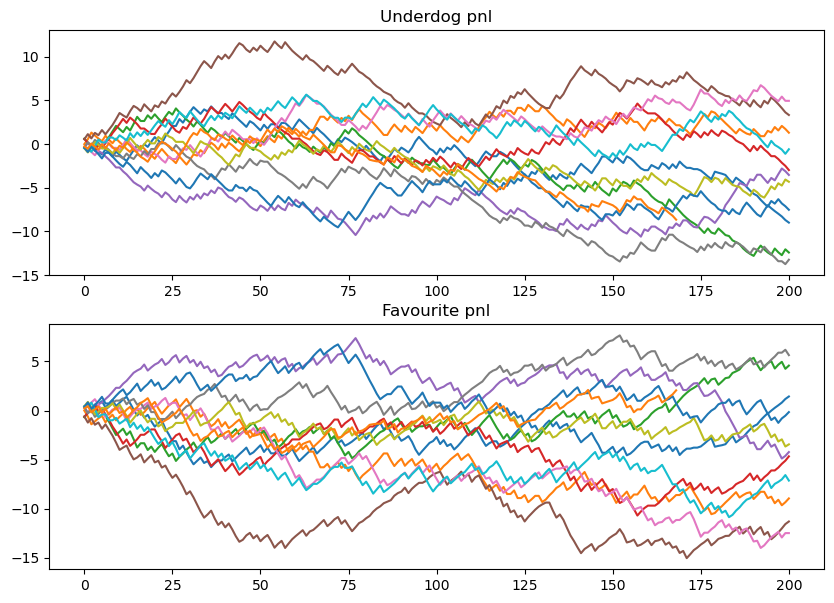

In [145]:
add_dog_pnl_inplace(train)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
years = train["year"].unique()
for year in years:
    year_df = train[train["year"] == year]
    ax[0].plot(range(len(year_df)), year_df["underdog_pnl"].cumsum())
    ax[1].plot(range(len(year_df)), year_df["favourite_pnl"].cumsum())
ax[0].set_title("Underdog pnl")
ax[1].set_title("Favourite pnl")
plt.show()

In [146]:
get_sharpe(train[["underdog_pnl", "favourite_pnl"]])

underdog_pnl    -2.365616
favourite_pnl   -1.736950
dtype: float64

Let's try the strat of placing a bet on the favourite if they are the home team. 

In [147]:
train["double_strat_pnl"] = np.where(
    train["home_ask"] < 0.5,
    train["pro_home_pnl"],
    0
)

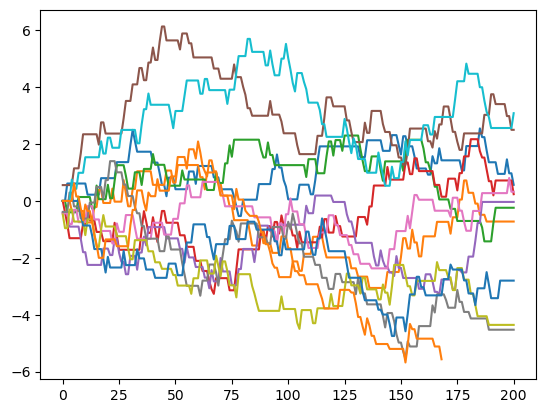

In [148]:
fig, ax = plt.subplots()
for year in years:
    year_df = train[train["year"] == year]
    ax.plot(range(len(year_df)), year_df["double_strat_pnl"].cumsum())
plt.show()

# Actual strat

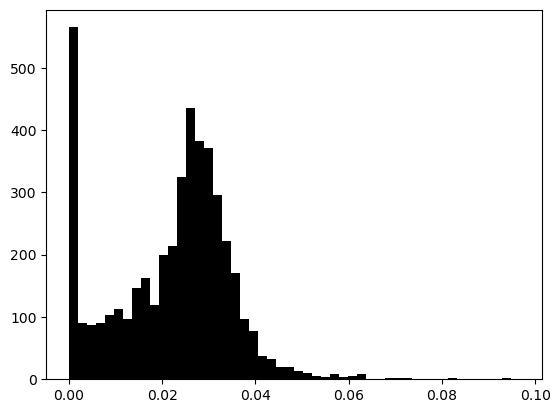

In [149]:
fig, ax = plt.subplots()
ax.hist(pd.concat([train["home_cli"], train["away_cli"]]), bins=50, color="black")
plt.show()

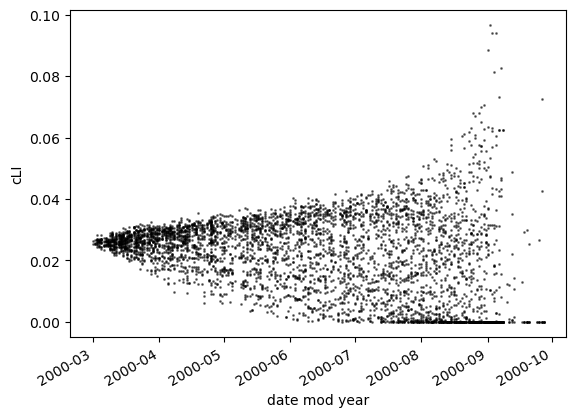

In [150]:
fig, ax = plt.subplots()
for side in ["home", "away"]:
    ax.scatter(train["date_mod_year"], train[f"{side}_cli"], s=1, color="black", alpha=0.5)
ax.set_xlabel("date mod year")
ax.set_ylabel("cLI")
plt.gcf().autofmt_xdate()
plt.show()

In [151]:
total_cli = pd.concat([train["home_cli"], train["away_cli"]])
print(f"Bottom quantile: {total_cli.quantile(0.1):.3f}")
print(f"Top quantile: {total_cli.quantile(0.9):.3f}")

Bottom quantile: 0.000
Top quantile: 0.035


In [152]:
train.dropna(inplace=True) # get rid of finals rounds, which don't have cli

In [154]:
def get_mean_pnl_centre(df, home_centre, away_centre, radius, direction):
    distance = (
        (df["home_cli"] - home_centre) ** 2
        + (df["away_cli"] - away_centre) ** 2
    )
    weights = np.exp(-distance / radius)
    pnl = df[f"{direction}_home_pnl"] * weights
    sharpe = get_sharpe(pnl)
    return sharpe, pnl.sum(), weights.sum()

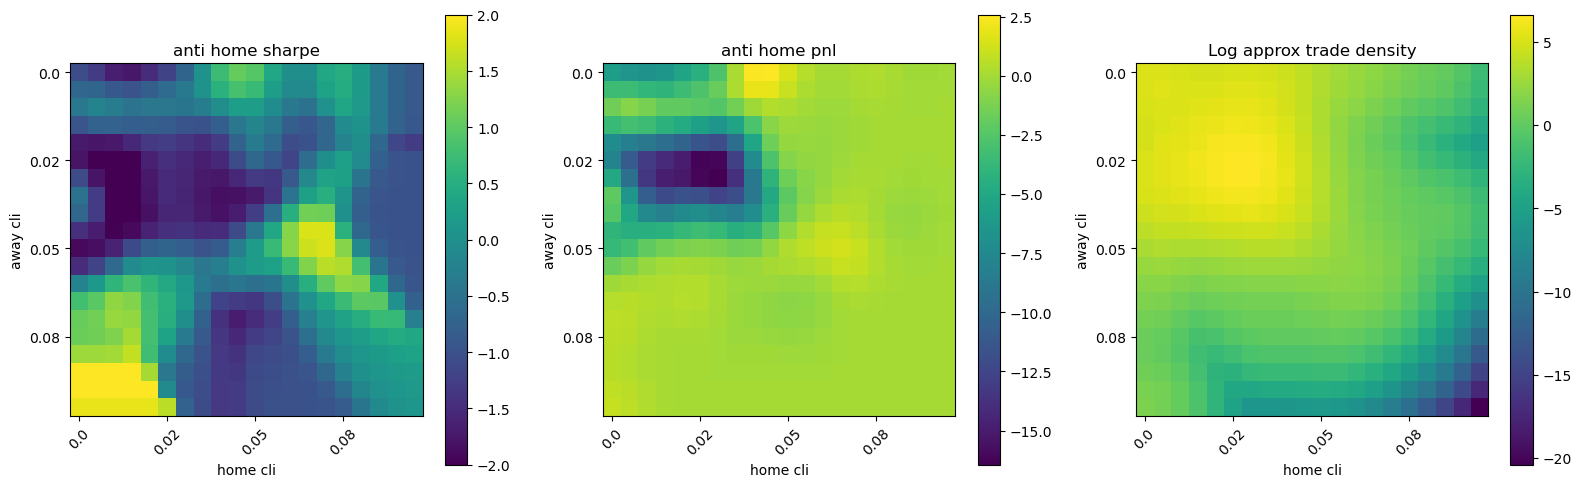

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
home_ticks = np.arange(0, 0.1, 0.005)
away_ticks = np.arange(0, 0.1, 0.005)
radius = 0.0001
direction = "anti"

temp_np = np.array([
    [
        get_mean_pnl_centre(train, home_centre, away_centre, radius, direction)
        for home_centre in home_ticks
    ]
    for away_centre in away_ticks
])
sharpe_df = pd.DataFrame(temp_np[:,:,0], index=away_ticks, columns=home_ticks)
pnl_df = pd.DataFrame(temp_np[:,:,1], index=away_ticks, columns=home_ticks)
count_df = pd.DataFrame(np.log(temp_np[:,:,2]), index=away_ticks, columns=home_ticks)

im_0 = ax[0].imshow(sharpe_df, vmin=-2, vmax=2)
im_1 = ax[1].imshow(pnl_df)
im_2 = ax[2].imshow(count_df)
for im in [im_0, im_1, im_2]:
    plt.colorbar(im)
for i in range(3):
    ax[i].set_xlabel(f"home cli")
    ax[i].set_ylabel(f"away cli")
    cut = 5
    ax[i].set_xticks(list(range(len(home_ticks)))[::cut], np.round(home_ticks[::cut], decimals=2), rotation=45)
    ax[i].set_yticks(list(range(len(away_ticks)))[::cut], np.round(away_ticks[::cut], decimals=2))
ax[0].set_title(f"{direction} home sharpe")
ax[1].set_title(f"{direction} home pnl")
ax[2].set_title("Log approx trade density")
plt.tight_layout()
plt.show()

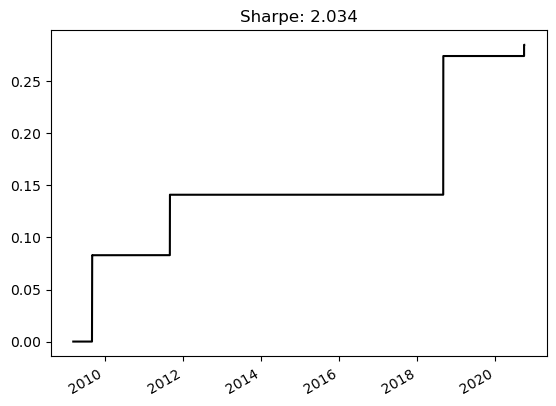

In [156]:
distance = (
    (train["home_cli"] - 0.01) ** 2
    + (train["away_cli"] - 0.09) ** 2
)
weights = np.exp(-distance / 0.0001)
pnl = weights * train["anti_home_pnl"]

fig, ax = plt.subplots()
ax.plot(pd.to_datetime(train["date"]), pnl.cumsum(), color="black")
ax.set_title(f"Sharpe: {get_sharpe(pnl):.3f}")
plt.gcf().autofmt_xdate()
plt.show()

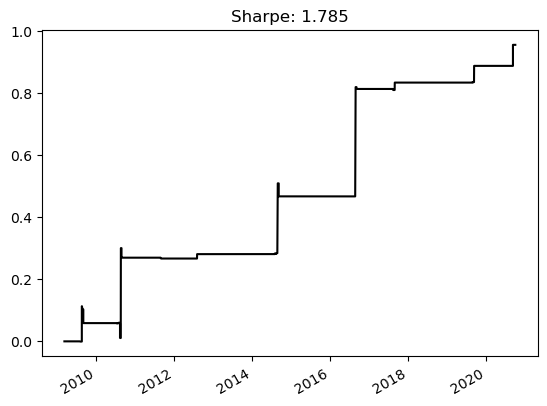

In [157]:
distance = (
    (train["home_cli"] - 0.07) ** 2
    + (train["away_cli"] - 0.05) ** 2
)
weights = np.exp(-distance / 0.0001)
pnl = weights * train["anti_home_pnl"]

fig, ax = plt.subplots()
ax.plot(pd.to_datetime(train["date"]), pnl.cumsum(), color="black")
ax.set_title(f"Sharpe: {get_sharpe(pnl):.3f}")
plt.gcf().autofmt_xdate()
plt.show()